### TLDR: Sine activation function is better than ReLU for reconstructing images

::: {layout-ncol=2}
![Reconstruction from ReLU](mlp_dog.png)

![Reconstruction from Sine](mlp_sine_dog.png)
:::

### Animation of the training process
::: {layout-ncol=2}
![Reconstruction from ReLU](mlp.gif)

![Reconstruction from Sine](mlp_sine.gif)
:::



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2023-04-27 17:21:53--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.138.128.23, 108.138.128.8, 108.138.128.34, ...
Connecting to segment-anything.com (segment-anything.com)|108.138.128.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   400KB/s    in 0.5s    

2023-04-27 17:21:55 (400 KB/s) - ‘dog.jpg’ saved [221810/221810]



In [5]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")


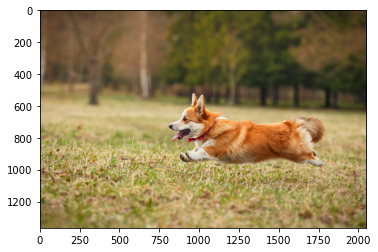

In [6]:
plt.imshow(img.permute(1, 2, 0))

In [7]:
# Normalize the image
img = img / 255.0

In [8]:
img.shape


torch.Size([3, 1365, 2048])

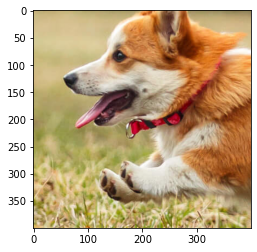

In [9]:
# Take a random 224x224 crop of the image
crop = torchvision.transforms.functional.crop(img, 600, 750, 400, 400)


# Plot the crop
plt.imshow(crop.permute(1, 2, 0))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape

# Create a 2D grid of (x,y) coordinates
x_coords = torch.arange(width).repeat(height, 1)
y_coords = torch.arange(height).repeat(width, 1).t()
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([x_coords, y_coords], dim=1).float()

# Move X to GPU if available
X = X.to(device)

In [12]:
num_xy = height * width
num_xy

160000

In [13]:
X.shape, X

(torch.Size([160000, 2]),
 tensor([[  0.,   0.],
         [  1.,   0.],
         [  2.,   0.],
         ...,
         [397., 399.],
         [398., 399.],
         [399., 399.]], device='cuda:0'))

In [14]:
# Extract pixel values from image tensor
pixel_values = crop.reshape(num_channels, -1).float().to(device)

# Transpose the pixel values to be (num_xy, num_channels)
pixel_values = pixel_values.transpose(0, 1)

y = pixel_values.to(device)

In [15]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

In [16]:
# Training loop function to train the model
# X: (num_xy, 2) tensor of (x, y) coordinates
# y: (num_xy, 3) tensor of (r, g, b) pixel values
# model: MLP model
# lr: learning rate
# epochs: number of epochs to train for
# bs: batch size
# print_every: print loss every print_every epochs
# Logs losses
# Saves the prediction frmo model every print_every epochs

def train(X, y, model, lr=0.01, epochs=1000, bs=1000, print_every=100):
    losses = []
    imgs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        # Get a random batch of (x, y) coordinates
        idxs = torch.randperm(num_xy)[:bs]
        batch_X = X[idxs]
        batch_y = y[idxs]

        # Predict the (r, g, b) values
        pred_y = model(batch_X)

        # Compute the loss
        loss = criterion(pred_y, batch_y)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Print loss every print_every epochs
        if epoch % print_every == 0:
            print(f"Epoch {epoch} loss: {loss.item()}")
            with torch.no_grad():
                # Predict the (r, g, b) values
                pred_y = model(X)

                # Reshape the predictions to be (3, height, width)
                pred_y = pred_y.transpose(0, 1).reshape(num_channels, height, width)
                imgs.append(pred_y.permute(1, 2, 0).detach().cpu())
                
    return losses, imgs

In [17]:
m1 = MLP()
m1 = m1.to(device)
losses_mlp, imgs = train(X, y, m1, lr=0.001, epochs=4000, bs=2000, print_every=100)

Epoch 0 loss: 1.7018471956253052
Epoch 100 loss: 0.06603028625249863
Epoch 200 loss: 0.057235319167375565
Epoch 300 loss: 0.0404510535299778
Epoch 400 loss: 0.032524872571229935
Epoch 500 loss: 0.03218328207731247
Epoch 600 loss: 0.0281166173517704
Epoch 700 loss: 0.026243779808282852
Epoch 800 loss: 0.026163198053836823
Epoch 900 loss: 0.032519325613975525
Epoch 1000 loss: 0.024566831067204475
Epoch 1100 loss: 0.026106974110007286
Epoch 1200 loss: 0.023526424542069435
Epoch 1300 loss: 0.024912869557738304
Epoch 1400 loss: 0.02449740841984749
Epoch 1500 loss: 0.026605552062392235
Epoch 1600 loss: 0.023133983835577965
Epoch 1700 loss: 0.021824147552251816
Epoch 1800 loss: 0.02422747202217579
Epoch 1900 loss: 0.02141580730676651
Epoch 2000 loss: 0.021704325452446938
Epoch 2100 loss: 0.021238207817077637
Epoch 2200 loss: 0.020268023014068604
Epoch 2300 loss: 0.02335718832910061
Epoch 2400 loss: 0.022202150896191597
Epoch 2500 loss: 0.021824292838573456
Epoch 2600 loss: 0.02258421108126640

In [18]:
def plot_image(model, name=None):
    # Predict the (r, g, b) values
    pred_y = model(X)

    # Reshape the predictions to be (3, height, width)
    pred_y = pred_y.transpose(0, 1).reshape(num_channels, height, width)

    # plot the image
    plt.imshow(pred_y.permute(1, 2, 0).detach().cpu())
    if name:
        plt.savefig(name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


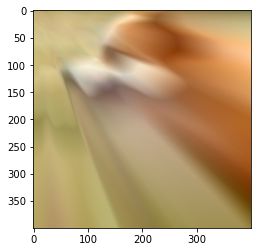

In [19]:
plot_image(m1, "mlp_dog.png")

In [20]:
# Create the animation from imgs and save it as a gif

import imageio
imageio.mimsave('mlp.gif', imgs, fps=10)

Lossy conversion from float32 to uint8. Range [-0.04191233217716217, 11.619576454162598]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.015796728432178497, 1.0159718990325928]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.2138720452785492, 1.3822332620620728]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Conver

![](mlp.gif)

In [21]:
# Create a MLP with 5 hidden layers with 256 neurons each and sine activations.
# Input is (x, y) and output is (r, g, b)

class MLP_sin(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = torch.sin(self.fc3(x))
        x = torch.sin(self.fc4(x))
        x = torch.sin(self.fc5(x))
        return self.fc6(x)

In [22]:
m2 = MLP_sin()
m2 = m2.to(device)
losses_mlp_sin, imgs = train(X, y, m2, lr=0.001, epochs=4000, bs=1000, print_every=100)

Epoch 0 loss: 0.4140782356262207
Epoch 100 loss: 0.032359253615140915
Epoch 200 loss: 0.0332462452352047
Epoch 300 loss: 0.03306599333882332
Epoch 400 loss: 0.035197194665670395
Epoch 500 loss: 0.03281615674495697
Epoch 600 loss: 0.03210144862532616
Epoch 700 loss: 0.03043728694319725
Epoch 800 loss: 0.03237061947584152
Epoch 900 loss: 0.02993330918252468
Epoch 1000 loss: 0.029848601669073105
Epoch 1100 loss: 0.02743176929652691
Epoch 1200 loss: 0.02384163625538349
Epoch 1300 loss: 0.022624002769589424
Epoch 1400 loss: 0.020442385226488113
Epoch 1500 loss: 0.01847166381776333
Epoch 1600 loss: 0.01679316535592079
Epoch 1700 loss: 0.01421322114765644
Epoch 1800 loss: 0.011823665350675583
Epoch 1900 loss: 0.009320917539298534
Epoch 2000 loss: 0.007692331448197365
Epoch 2100 loss: 0.006010274402797222
Epoch 2200 loss: 0.005269041284918785
Epoch 2300 loss: 0.004415140487253666
Epoch 2400 loss: 0.003827098524197936
Epoch 2500 loss: 0.0033653767313808203
Epoch 2600 loss: 0.0028291847556829453

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


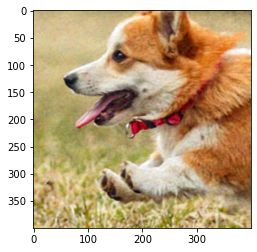

In [23]:
plot_image(m2, "mlp_sin_dog.png")

In [25]:
imageio.mimsave('mlp_sin.gif', imgs, fps=10)

Lossy conversion from float32 to uint8. Range [-0.14863309264183044, 0.2620331943035126]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conver

![](mlp_sin.gif)